Our goal is to obtain a distribution of the distances from the identity to a random matrix, and use that distribution to see if we can distinguish significant covariances from non-significant ones. There's many ways to pick a 'random matrix', and for starters we'll chose that to mean the covariance matrix of a series of uncorrelated standard normal k-vectors.

We'll be using the following distance in riemannian affine-invariant metric:

$d(S_1, S_2) = \|\log(S_1^{-1} S_2)\|_F = \left(\sum_{i=1}^m \log^2 \lambda_i(S_1,S_2)\right)^{1/2}$

where the $\lambda_i(S_1,S_2)$ are the generalized eigenvalues of $S_1$ with respect to $S_2$ (i.e., solutions of the eigenvalue equation $S_1 v=\lambda S_2 v$)

Geodesic path between two matrices S1 and S2 in this manifold:

$\gamma : t \in [0, 1] \rightarrow S_1^{1/2} \left(S_1^{-1/2} S_2 S_1^{-1/2}\right)^t S_1^{1/2}$

The advantage here is that the formula simplifies when one of the matrices in question is the identity, giving

$d(I_m, S_2) = \left(\sum_{i=1}^m \log^2 \lambda_i\right)^{1/2}$

in this case the $\lambda_i$'s are just the eigenvalues of $S_2$, which can usually be obtained easily.

We'll make two assumptions to begin with, and then explore how they affect the outcome when they're lifted. We'll use matrices that are $4\times4$, and with $30$ degrees of freedom. This would correspond to having four variables with thirty observations each, and looking at their covariance.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import (
    expm, logm, sqrtm, eigh, fractional_matrix_power, eigvals)
from scipy.stats import wishart
import seaborn as sns

In [17]:
df = 30
cols = 4

sample = np.cov(np.random.normal(size=(cols,df)))
sample.shape # sanity check for the shape of the covariance matrix

(4, 4)

In [18]:
def riem_dist_to_id(S1):
  '''
  Computes the riemannian distance from S1 to the identity
  '''
  w = np.real(eigvals(S1)) # the imaginary components are all zero anyways because of symmetry
  w = w[w>0] #in case some computing error gave us negative eigenvalues
  logsq_w = np.log(w)**2
  sum = np.sqrt(np.sum(logsq_w))
  return sum

In [60]:
np.random.seed(394223)

distances_H0 = []
reps = 5000
for k in range(reps):
  sample = np.cov(np.random.normal(size=(cols,df), scale=1))
  distances_H0.append(riem_dist_to_id(sample))

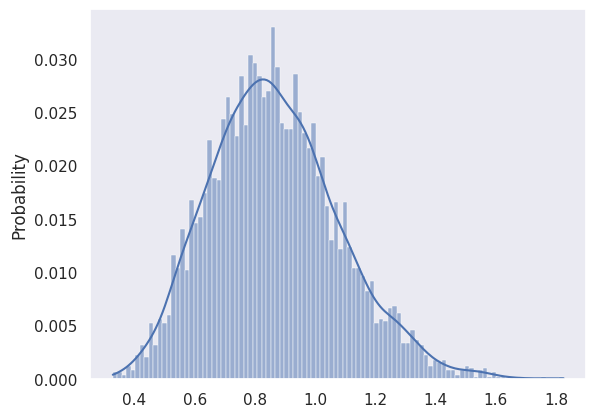

In [61]:
sns.histplot(distances_H0, kde=True, bins=100, stat="probability")
plt.show()

We can see that the distribution of distances from the identity (in riemannian distance) centered adount 0.8 and is slightly skewed to the right.

This would, in principle, depend on the degrees of freedom and the number of covariates.

In [15]:
# Toy example:

col1 = [k for k in range(df)]
col2 = [col1[k]+k*np.sin(k/5) for k in range(df)]
col3 = [1/(k+1) for k in range(df)]
col4 = [np.sin(k) for k in range(df)]

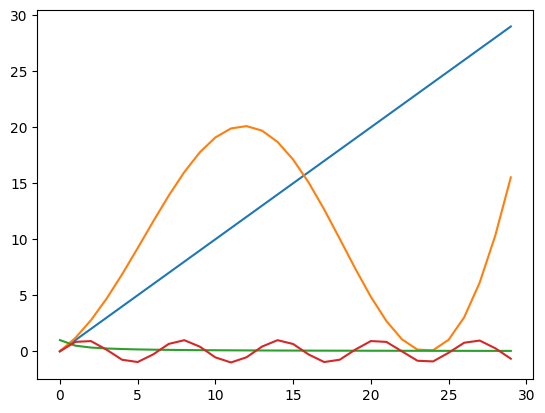

In [16]:
for i in [col1,col2,col3,col4]:
  plt.plot(i)

We've created a toy example as a sanity check, with four deterministic functions, hoping to see a higher distance than we'd expect from the random matrices.

In [18]:
non_rand = np.cov(np.array([col1,col2,col3,col4]))
print(np.array_str(non_rand, precision=2, suppress_small=True))

[[77.5  -8.32 -1.1  -0.31]
 [-8.32 50.   -0.45 -0.42]
 [-1.1  -0.45  0.04  0.01]
 [-0.31 -0.42  0.01  0.5 ]]


This is clearly an extreme example but we'd still expect a higher distance.

[]

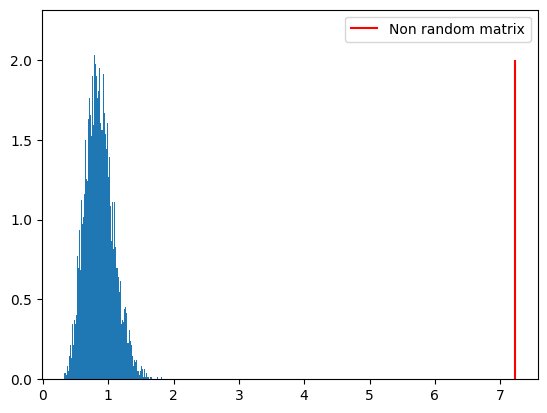

In [23]:
plt.hist(distances_H0, bins=100, density=True)
plt.vlines(riem_dist_to_id(non_rand), ymin=0, ymax= 2 , label="Non random matrix", colors="red")
plt.legend()
plt.plot()

Now we have to see how we can use this.

## Noise removal

The idea is the following: if we have a matrix with a certain distance to the identity, we can see how the addition of noise affects this distance, and if, perhaps, we can use our distribution of noisy matrices to de-noise the original matrix and get an estimate of the underlying covariance.

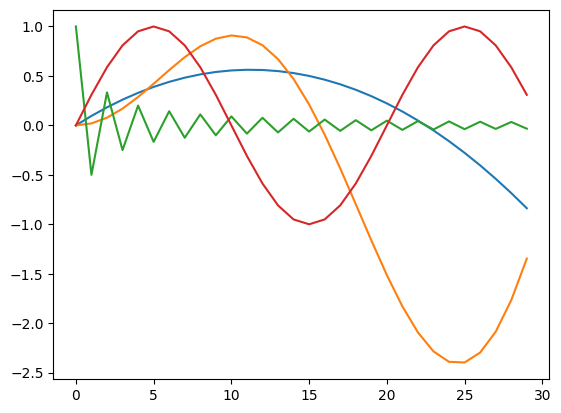

In [29]:
# Toy data Number 2:
col1 = [k/10-(k/15)**2 for k in range(df)]
col2 = [k/10*np.sin(k/5) for k in range(df)]
col3 = [(-1)**k/(k+1) for k in range(df)]
col4 = [np.sin(k*np.pi/10) for k in range(df)]

for i in [col1,col2,col3,col4]:
  plt.plot(i)

In [30]:
base_matrix = np.cov(np.array([col1,col2,col3,col4]))
print(np.array_str(base_matrix, precision=2, suppress_small=True))

[[ 0.16  0.37 -0.   -0.13]
 [ 0.37  1.44  0.01 -0.29]
 [-0.    0.01  0.06 -0.01]
 [-0.13 -0.29 -0.01  0.47]]


In [31]:
riem_dist_to_id(base_matrix)

4.298003152805011

We can see this matrix, even though the covariance is much weaker than the previous example, has a distance that's higher than the random expected distances.

We'll see how the distance changes as we add noise first.

In [39]:
dist_by_noise = []
for k in range(30):
  dst_k = riem_dist_to_id(
      np.cov(
          np.array([col1,col2,col3,col4]) + np.random.normal(size=(cols,df), scale=k/10)))
  dist_by_noise.append(dst_k)

[]

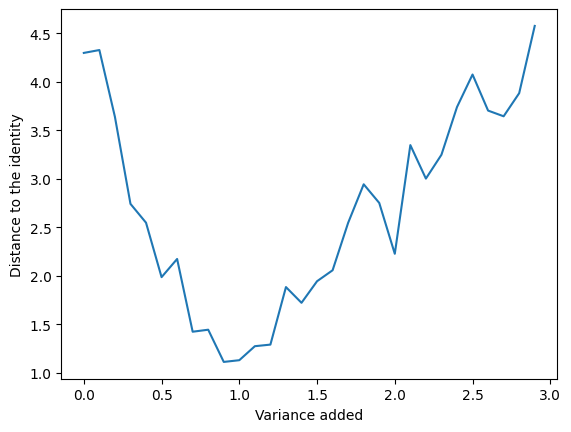

In [41]:
plt.plot([k/10 for k in range(30)],dist_by_noise)
plt.xlabel("Variance added")
plt.ylabel("Distance to the identity")
plt.plot()

On the one hand it makes sense that the distance decreases as a function of the variance, but the increase after is an indicator of a distorsion of the covariance that's big enough to get further away than the original matrix ever was.

Let's explore this over different iterations to see if this behavior replicates

[]

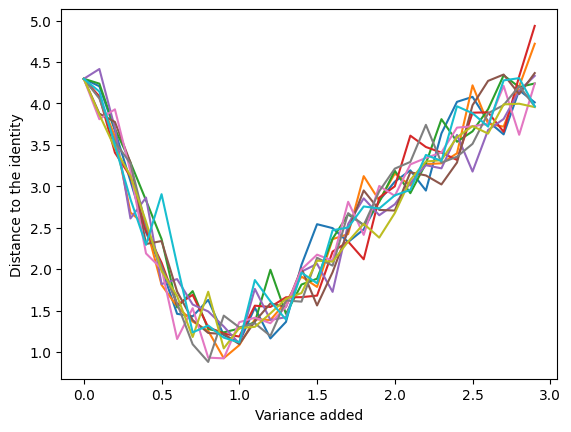

In [44]:
reps = 10
xaxis = [k/10 for k in range(30)]
for j in range(reps):
  dist_by_noise = []
  for k in range(30):
    dst_k = riem_dist_to_id(
        np.cov(
            np.array([col1,col2,col3,col4]) + np.random.normal(size=(cols,df), scale=k/10)))
    dist_by_noise.append(dst_k)
  plt.plot(xaxis,dist_by_noise)

plt.xlabel("Variance added")
plt.ylabel("Distance to the identity")
plt.plot()

This of course has to do with the variance added being larger than the original entries of the matrix. What's not clear is why, if the variance added obscures the original relationship between the covariates making into a random noise function, why the distances are increasing. Perhaps the original distribution also depends on the variances of the gaussian noise matrix.

Let's explore this now.

## Distributions for different degrees of freedom, variances, and covariates.

In [64]:
def gen_distrib(scale=1, cols=4, df=30, reps = 5000):
  distances_H0 = []
  for k in range(reps):
    sample = np.cov(np.random.normal(size=(cols,df), scale = scale))
    distances_H0.append(riem_dist_to_id(sample))
  return distances_H0

### Variance

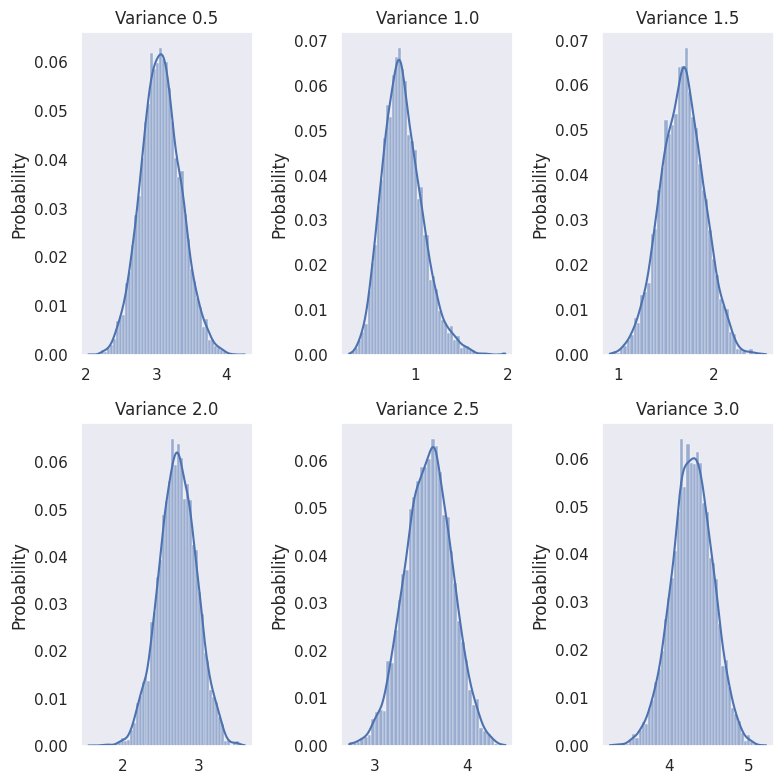

In [53]:
sns.set(style="dark")
f = plt.figure(tight_layout=True, figsize=(8, 8))
for i in range(6):
    f.add_subplot(2, 3, i+1)
    sns.histplot(gen_distrib(scale=(i+1)/2), kde=True, stat="probability").set(title=f"Variance {(i+1)/2}")
plt.show()

We see there is clearly some positive relationship between variance and the mean of our distribution.

An interesting phenomenon happens when the variance gets smaller, where the mean seems to get larger. This could be because of the matrix becoming close to zero, and it's eigenvalues pointing in many different directions with an inflated magnitude.

### Degrees of freedom

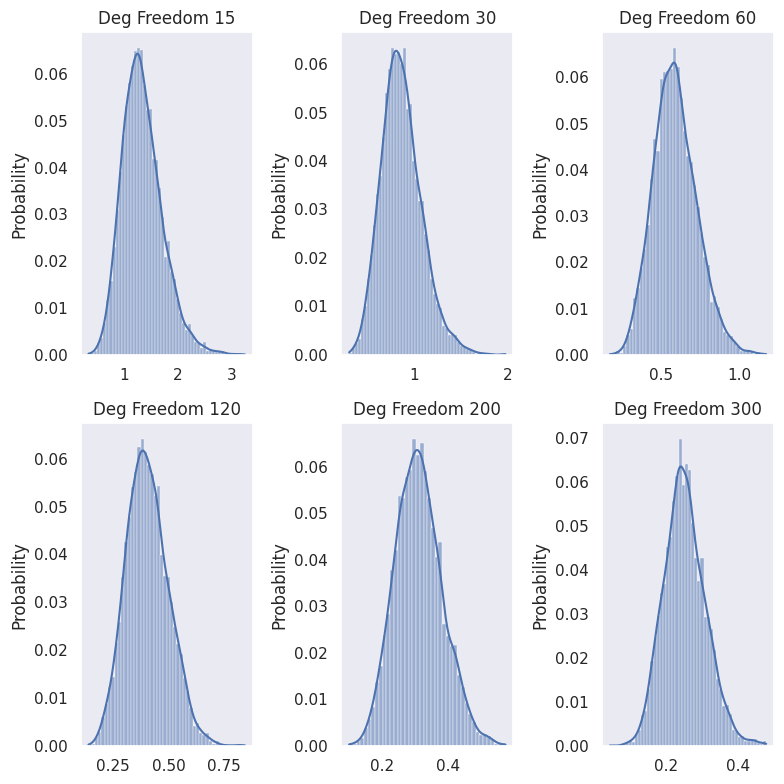

In [62]:
sns.set(style="dark")
f = plt.figure(tight_layout=True, figsize=(8, 8))
DF = [15, 30, 60, 120, 200, 300]
for i in range(6):
    f.add_subplot(2, 3, i+1)
    sns.histplot(gen_distrib(df=DF[i]), kde=True, stat="probability").set(title=f"Deg Freedom {DF[i]}")
plt.show()

This, interestingly, seems to converge to some distribution as the degrees of freedom increase. This would correspond to various limiting processes that are common in random matrix theory, and we expect to see that as well now that we'll vary the number of variables...

### Covariates

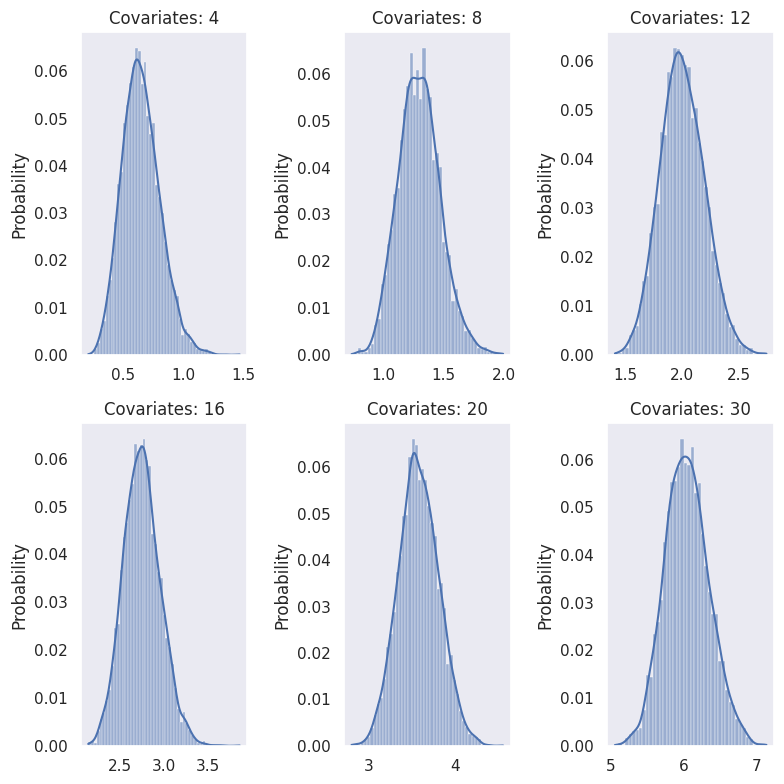

In [66]:
sns.set(style="dark")
f = plt.figure(tight_layout=True, figsize=(8, 8))
Covs = [4, 8, 12, 16, 20, 30]
for i in range(6):
    f.add_subplot(2, 3, i+1)
    sns.histplot(gen_distrib(cols=Covs[i], df=50), kde=True, stat="probability").set(title=f"Covariates: {Covs[i]}")
plt.show()

We see a distibution that shifts to the right with the number of covariates. Perhaps we will see something more stable if we divide the distances by the number of columns. Let's try that.

### Mean distance

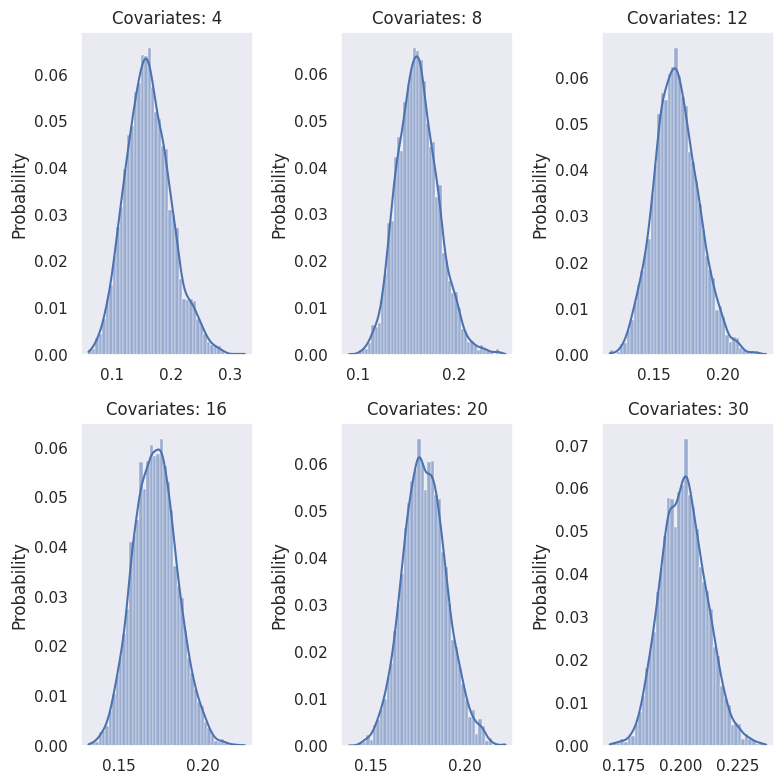

In [67]:
sns.set(style="dark")
f = plt.figure(tight_layout=True, figsize=(8, 8))
Covs = [4, 8, 12, 16, 20, 30]
for i in range(6):
    f.add_subplot(2, 3, i+1)
    dist_array = np.array(gen_distrib(cols=Covs[i], df=50))/Covs[i]
    sns.histplot(dist_array, kde=True, stat="probability").set(title=f"Covariates: {Covs[i]}")
plt.show()

This appears to stabilize the distances.

We've seen two possibilities for a stable distribution arising: one from increasing degrees of freedom, and one from increasing the number of covariates.

Further investigation is still needed to arrive at analytical expressions for them or the uses in de-noising that were initially motivating this exploration.

## References

* https://hal.science/hal-00820475/document

* https://gmarti.gitlab.io/ml/2021/02/13/swelling-effect-spd-covariance.html

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wishart.html

